# PnP CTscan imaging of FASTMRI brain dataset

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this fifth notebook is to applying Plug-and-Play Priors to CTscan imaging. We will be using a single brain image from the training dataset (which we will always keep in the testing dataset to provide a fair comparison of different methods). 

The problem that we wish to solve can be expressed as:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; \Vert \mathbf{d}- \mathbf{G}\mathbf{m} \Vert_2^2 + \lambda R(\mathbf{m})
$$

where $R$ is an unspecified regularizer whose proximal operation is replaced by a pre-trained denoising network.


In [1]:
#### COLAB ####
COLAB = False # Set to False or True depending if you use local or Colab env. (everything else will work automatically)

In [2]:
if COLAB:
    !apt-get install automake libtool
    !pip install astra-toolbox pylops pyproximal

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
import pylops
import torch
import torch.nn as nn

from scipy.sparse.linalg import lsqr
from tqdm.notebook import tqdm, trange
from pylops import Identity
from pylops.utils.dottest import dottest
from pylops.utils.metrics import snr
from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from torchinfo import summary

from ct import CT2D
from drunet import UNetRes
from denoising import denoising
from primaldual import PlugAndPlay_PrimalDual, callback
from plotting import plt_comparison
from utils import set_seed

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

set_seed(42)
    
# astra.test()

## Parameters

In [4]:
device = torch.device('cuda:0') # 'cpu' 

# Primal-Dual parameters
tau = .1
mu = .5
sigma = .01 # sigma/mu is the extra channel of DRUNET
niter = 50 

## Load brain image and create CT data

In [5]:
# Load data
if not COLAB:
    brains = np.load('../data/brains_trainingdata.npy')
else:
    brains = np.load('/content/drive/My Drive/DA_SummerSchool_2023/brains_trainingdata.npy')
brain = brains[10]
nx, ny = brain.shape

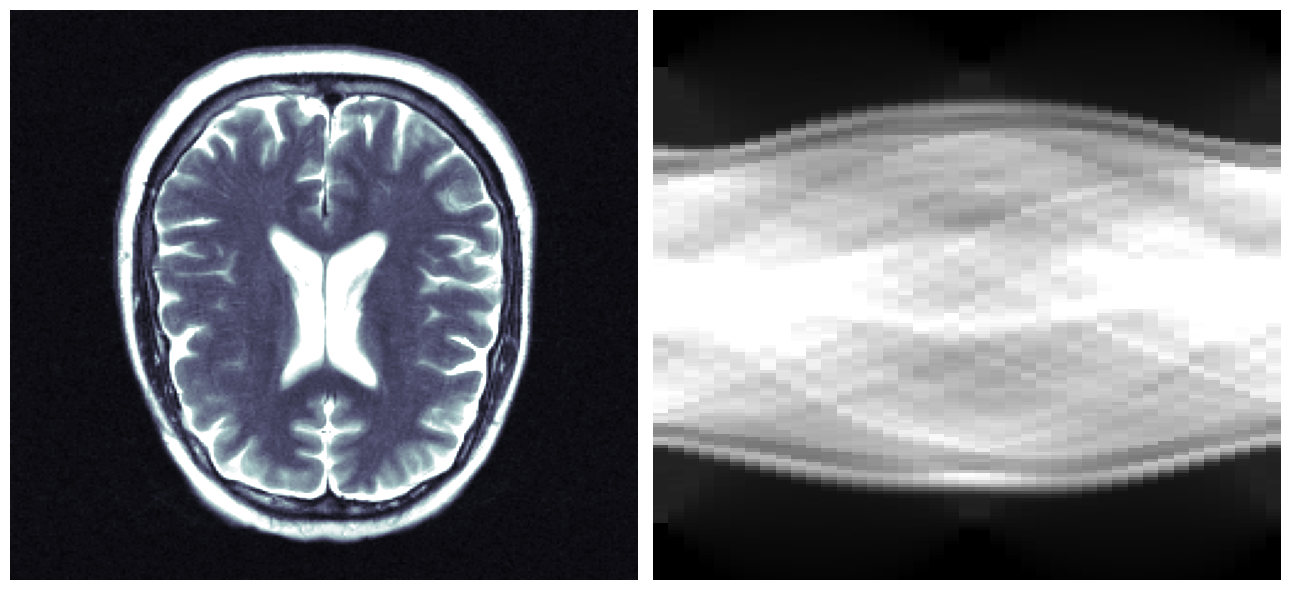

In [6]:
# Create data
nangles = 41
distdetectors = 2
ndetectors = 160

vol_geom = astra.create_vol_geom(nx, ny)
proj_geom = astra.create_proj_geom('parallel', distdetectors, ndetectors, 
                                   np.linspace(0, np.pi, nangles, False))

proj_id = astra.create_projector('strip', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino(brain, proj_id)

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].imshow(brain, vmin=0, vmax=.5, cmap='bone')
axs[0].axis('tight')
axs[0].axis('off')
axs[1].imshow(sinogram.T, cmap='gray', vmin=0, vmax=6e1)
axs[1].axis('tight')
axs[1].axis('off')
plt.tight_layout()

In [7]:
# Create operator
Cop = CT2D((nx, ny), distdetectors, ndetectors, np.linspace(0, np.pi, nangles, False))
dottest(Cop, atol=1e-3, verb=True)

Dot test passed, v^H(Opu)=826.8295344176697 - u^H(Op^Hv)=826.8290139358178


True

## Plug-and-Play prior

In [8]:
# Pre-trained DRUNet
drunet = UNetRes(in_nc=2)
drunet.load_state_dict(torch.load('../models/drunet_gray.pth'))
drunet.eval().to(device)
summary(drunet, (1, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNetRes                                  [1, 1, 128, 128]          --
├─Conv2d: 1-1                            [1, 64, 128, 128]         1,152
├─Sequential: 1-2                        [1, 128, 64, 64]          --
│    └─ResBlock: 2-1                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         73,728
│    └─ResBlock: 2-2                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-2              [1, 64, 128, 128]         73,728
│    └─ResBlock: 2-3                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-3              [1, 64, 128, 128]         73,728
│    └─ResBlock: 2-4                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-4              [1, 64, 128, 128]         73,728
│    └─Conv2d: 2-5                       [1, 128, 64, 64]          32,768
├─Sequential: 1-3                        [1, 256, 32, 32]     

/home/ravasim/Documents/2023/Teaching/DA_summerschool_2023/notebooks/plotting.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


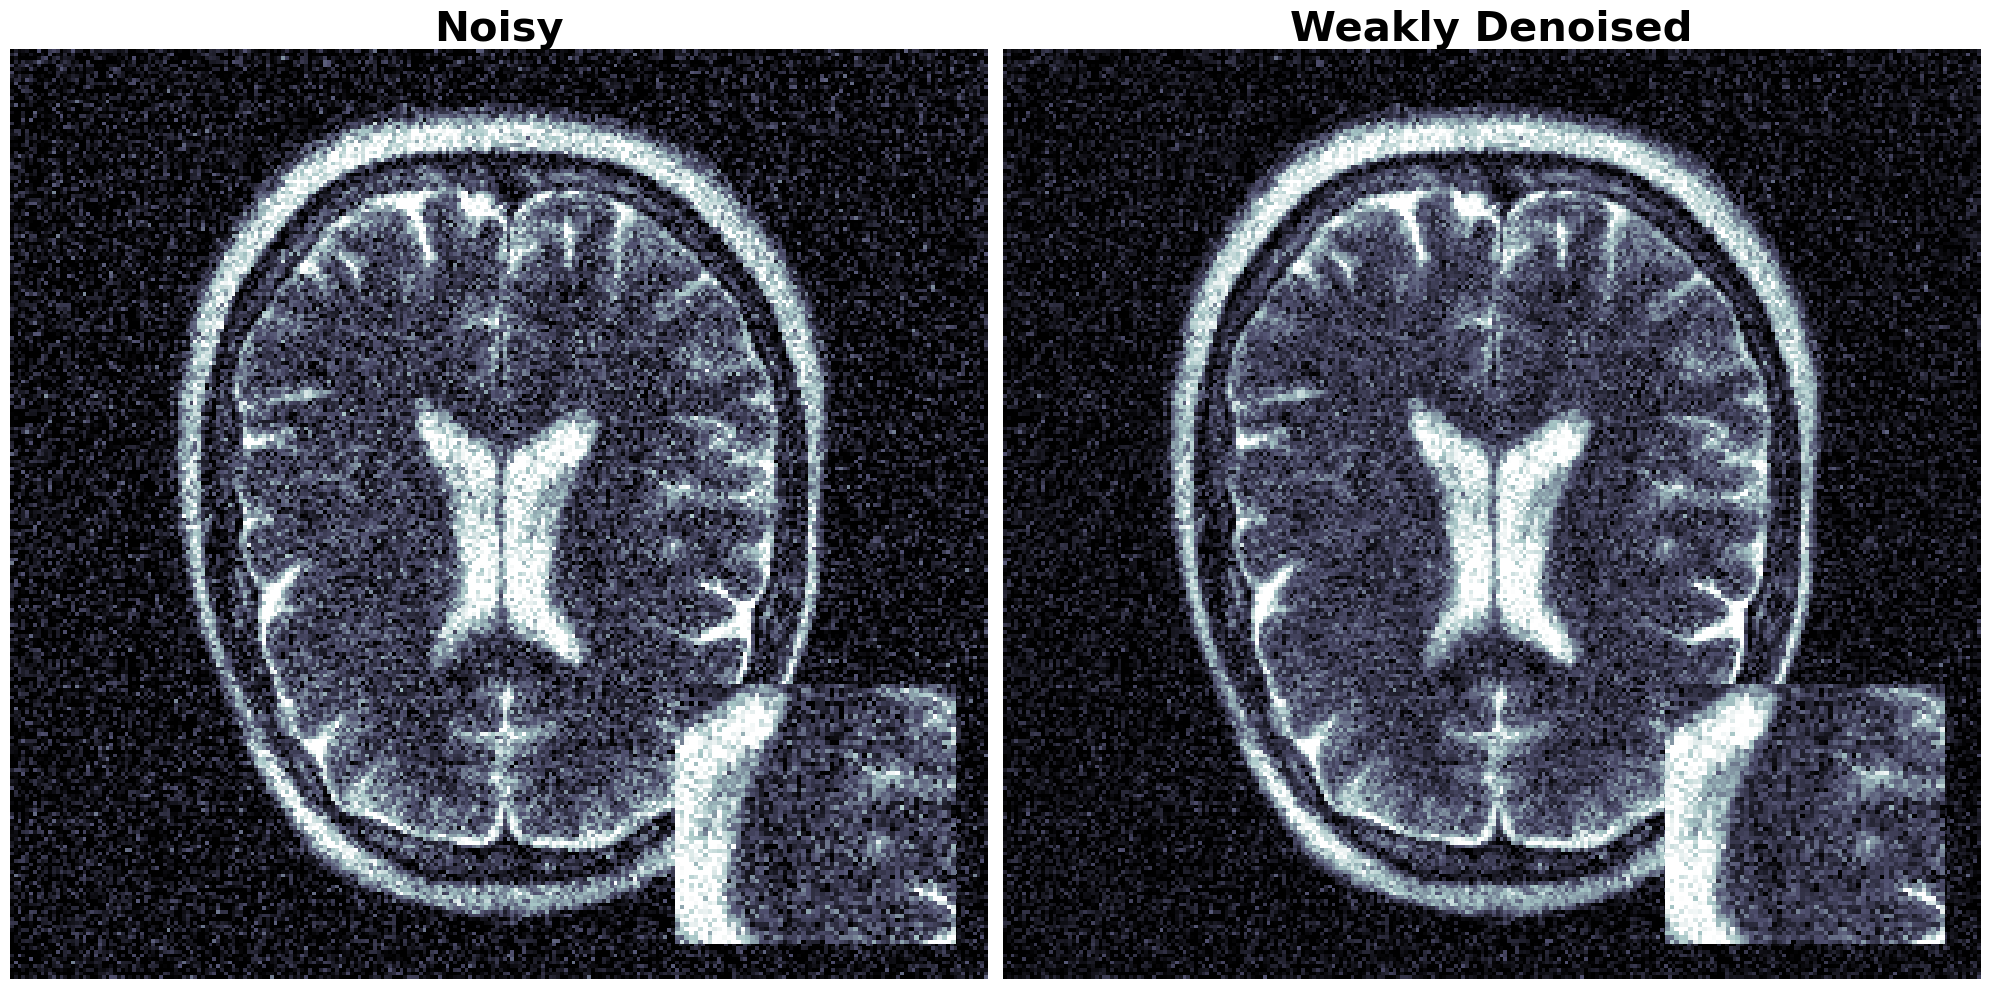

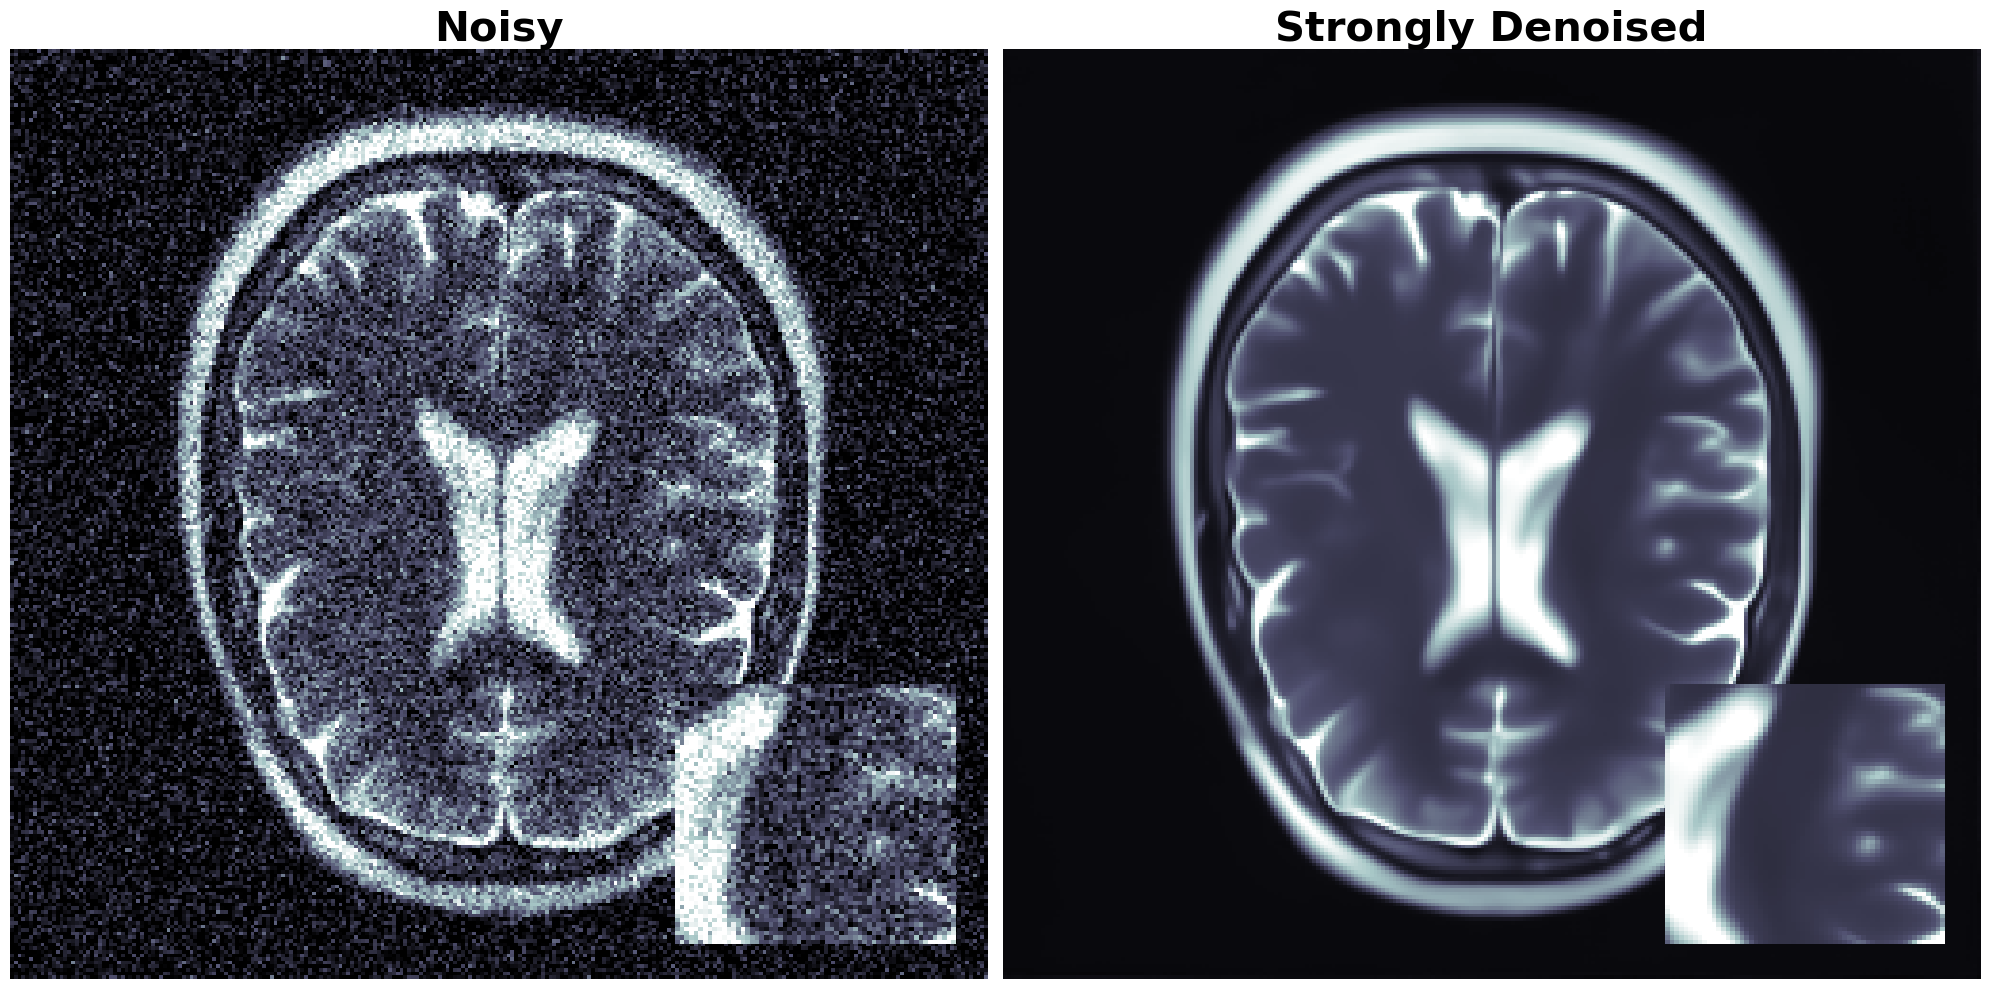

In [9]:
# Test denoiser
drunet.half(); # Make network half precision
denoiser_dn = lambda x, mu: denoising(drunet, torch.from_numpy(x).float(), mu, .001, 
                                      half=True, device=device, verb=False)

brainn = brain + np.random.normal(0, 0.1, (nx, ny))
brainden_weak  = denoiser_dn(brainn, 1)
brainden_strong = denoiser_dn(brainn, 5)

plt_comparison(brainn, brainden_weak, cmap='bone', clim=(0, 0.7), 
               titles=['Noisy', 'Weakly Denoised'], zoom=(100, 160, 130, 190))

plt_comparison(brainn, brainden_strong, cmap='bone', clim=(0, 0.7), 
               titles=['Noisy', 'Strongly Denoised'], zoom=(100, 160, 130, 190))

In [10]:
Iop = Identity(nx*ny)
l2 = L2(Op=Cop, b=sinogram.ravel(), x0=np.zeros(nx*ny), niter=20, warm=True)

drunet.half(); # Make network half precision
denoiser_dn = lambda x, mu: denoising(drunet, torch.from_numpy(x).float(), mu, sigma, 
                                      half=True, device=device, verb=False)

brainpnp = PlugAndPlay_PrimalDual(l2, denoiser_dn, Iop, (nx, ny),
                                  tau=tau, x0=Cop.H @ sinogram.ravel(), mu=mu,
                                  niter=niter, show=True)
brainpnp = brainpnp.reshape(nx, ny)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'primaldual._Denoise'>
Linear operator (A): <class 'pylops.basicoperators.identity.Identity'>
Additional vector (z): None
tau = 0.1		mu = 0.5
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.71745e-01   5.113e+08   0.000e+00   0.000e+00       5.113e+08
     2   3.25469e-02   1.185e+05   0.000e+00   0.000e+00       1.185e+05
     3   5.23660e-02   4.621e+03   0.000e+00   0.000e+00       4.621e+03
     4   5.49403e-02   2.462e+02   0.000e+00   0.000e+00       2.462e+02
     5   5.39565e-02   4.110e+01   0.000e+00   0.000e+00       4.110e+01
     6   5.81845e-02   2.659e+01   0.000e+00   0.000e+00       2.659e+01
     7   6.07935e-02   2.237e+01   0.000e+00   0.000e+00       2.237e+01
     8   6.52543e-02   2.413e+01   0.000e+00   0.000e+00  

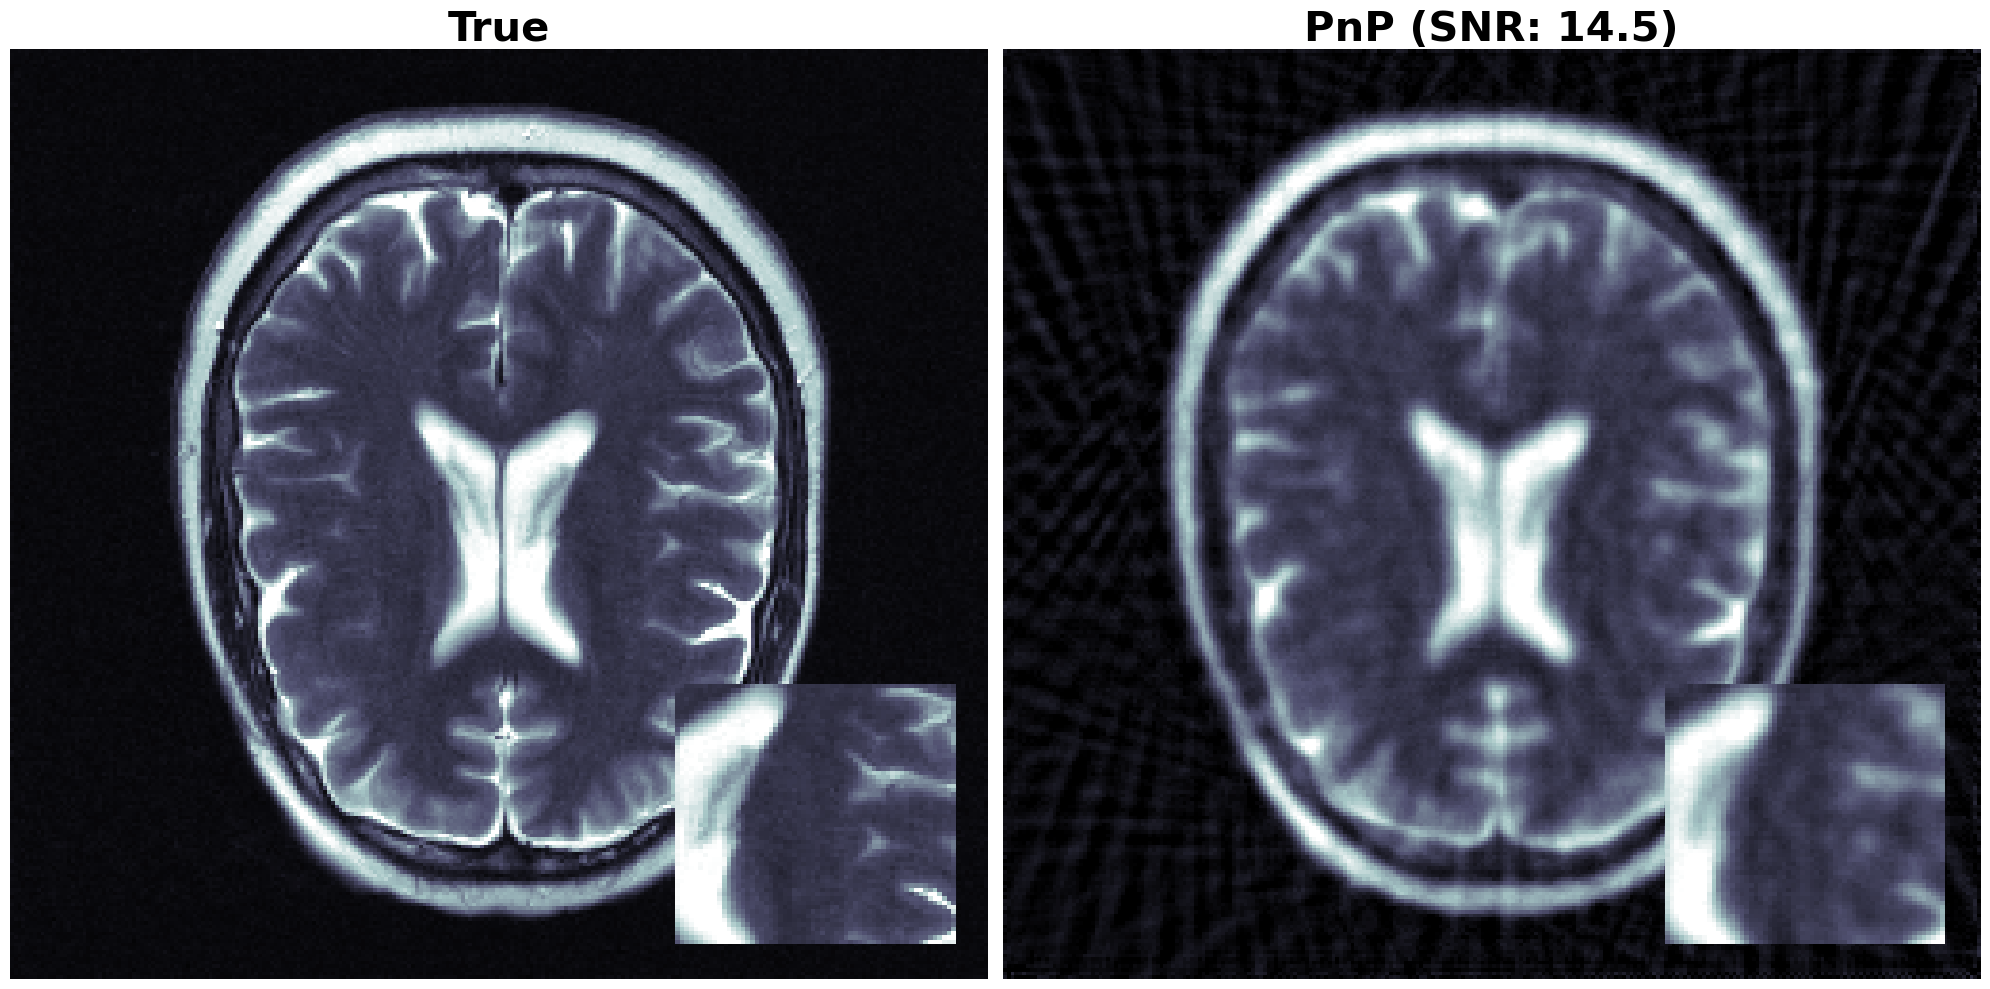

In [11]:
plt_comparison(brain, brainpnp, cmap='bone', clim=(0, 0.7), 
               titles=['True', 'PnP'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)